## Attrition Decision Tree | Day 24


#### Problem Statement:

A large company named XYZ, employs, at any given point of time, around 4000 employees. However, every year, around 15% of its employees leave the company and need to be replaced with the talent pool available in the job market. The management believes that this level of attrition (employees leaving, either on their own or because they got fired) is bad for the company, because of the following reasons -

The former employees projects get delayed, which makes it difficult to meet timelines, resulting in a reputation loss among consumers and partners
A sizeable department has to be maintained, for the purposes of recruiting new talent
More often than not, the new employees have to be trained for the job and/or given time to acclimatise themselves to the company

Hence, the management has contracted an HR analytics firm to understand what factors they should focus on, in order to curb attrition. In other words, they want to know what changes they should make to their workplace, in order to get most of their employees to stay. Also, they want to know which of these variables is most important and needs to be addressed right away.

Since you are one of the star analysts at the firm, this project has been given to you.

Goal of the case study You are required to model the probability of attrition. The results thus obtained will be used by the management to understand what changes they should make to their workplace, in order to get most of their employees to stay.




In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pandas_profiling import ProfileReport
import itertools
import scipy.stats as stats
from scipy.stats import ttest_1samp, ttest_ind,mannwhitneyu,wilcoxon,chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.power import ttest_power
from scipy.stats import linregress
# to build the models
from sklearn.linear_model import LogisticRegression

# to evaluate the models
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import log_loss
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('general_data.csv')
map_attrition = {'Yes': 1, 'No': 0}   # Convert the categorical object into numerical
df = df.replace({'Attrition': map_attrition})
map_Education = {1:'Below College' , 2:'College', 3:'Bachelor', 4:'Master', 5:'Doctor'}
df = df.replace({'Education': map_Education})
map_JobLevel = {1:'Low' , 2:'Medium', 3:'High', 4:'Very High', 5:'Exemplary'}
df = df.replace({'JobLevel': map_JobLevel})
df.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,51,0,Travel_Rarely,Sales,6,College,Life Sciences,1,1,Female,Low,Healthcare Representative,Married,131160,1.0,Y,11,8,0,1.0,6,1,0,0
1,31,1,Travel_Frequently,Research & Development,10,Below College,Life Sciences,1,2,Female,Low,Research Scientist,Single,41890,0.0,Y,23,8,1,6.0,3,5,1,4
2,32,0,Travel_Frequently,Research & Development,17,Master,Other,1,3,Male,Very High,Sales Executive,Married,193280,1.0,Y,15,8,3,5.0,2,5,0,3
3,38,0,Non-Travel,Research & Development,2,Doctor,Life Sciences,1,4,Male,High,Human Resources,Married,83210,3.0,Y,11,8,3,13.0,5,8,7,5
4,32,0,Travel_Rarely,Research & Development,10,Below College,Medical,1,5,Male,Low,Sales Executive,Single,23420,4.0,Y,12,8,2,9.0,2,6,0,4


In [3]:
#Since EmployeeID EmployeeCount and StandarHours are irrelevant variables and have no link with Attrition variable
#So we drop it.
df.drop(labels=['EmployeeID','EmployeeCount','StandardHours','Over18'],axis = 1,inplace=True)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4410 entries, 0 to 4409
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Age                      4410 non-null   int64  
 1   Attrition                4410 non-null   int64  
 2   BusinessTravel           4410 non-null   object 
 3   Department               4410 non-null   object 
 4   DistanceFromHome         4410 non-null   int64  
 5   Education                4410 non-null   object 
 6   EducationField           4410 non-null   object 
 7   Gender                   4410 non-null   object 
 8   JobLevel                 4410 non-null   object 
 9   JobRole                  4410 non-null   object 
 10  MaritalStatus            4410 non-null   object 
 11  MonthlyIncome            4410 non-null   int64  
 12  NumCompaniesWorked       4391 non-null   float64
 13  PercentSalaryHike        4410 non-null   int64  
 14  StockOptionLevel        

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,4410.0,36.923810,9.133301,18.0,30.0,36.0,43.0,60.0
Attrition,4410.0,0.161224,0.367780,0.0,0.0,0.0,0.0,1.0
DistanceFromHome,4410.0,9.192517,8.105026,1.0,2.0,7.0,14.0,29.0
MonthlyIncome,4410.0,65029.312925,47068.888559,10090.0,29110.0,49190.0,83800.0,199990.0
NumCompaniesWorked,4391.0,2.694830,2.498887,0.0,1.0,2.0,4.0,9.0
PercentSalaryHike,4410.0,15.209524,3.659108,11.0,12.0,14.0,18.0,25.0
StockOptionLevel,4410.0,0.793878,0.851883,0.0,0.0,1.0,1.0,3.0
TotalWorkingYears,4401.0,11.279936,7.782222,0.0,6.0,10.0,15.0,40.0
TrainingTimesLastYear,4410.0,2.799320,1.288978,0.0,2.0,3.0,3.0,6.0
YearsAtCompany,4410.0,7.008163,6.125135,0.0,3.0,5.0,9.0,40.0


In [6]:
# Let us look at the target column which is 'Attrition' to understand how the data is distributed amongst the various values
df.groupby(["Attrition"]).count()

,Age,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
Attrition,,,,,,,,,,,,,,,,,,,
0,3699,3699,3699,3699,3699,3699,3699,3699,3699,3699,3699,3684,3699,3699,3692,3699,3699,3699,3699
1,711,711,711,711,711,711,711,711,711,711,711,707,711,711,709,711,711,711,711


<AxesSubplot:xlabel='Attrition', ylabel='count'>

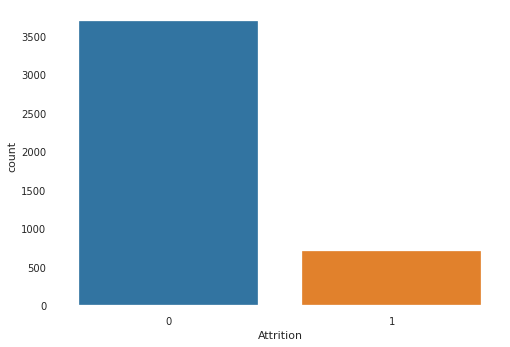

In [7]:
sns.countplot(x='Attrition', data=df)

In [8]:
#missing data => Find total rows having missing values and calculate the percentage of missing values for each field.
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
NumCompaniesWorked,19,0.004308
TotalWorkingYears,9,0.002041
YearsWithCurrManager,0,0.000000
JobLevel,0,0.000000
Attrition,0,0.000000
BusinessTravel,0,0.000000
Department,0,0.000000
DistanceFromHome,0,0.000000
Education,0,0.000000
EducationField,0,0.000000


In [9]:
#Let us drop the na values as they are minimal here 
df.dropna(inplace=True)

In [10]:
#missing data => Find total rows having missing values and calculate the percentage of missing values for each field.
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
YearsWithCurrManager,0,0.0
YearsSinceLastPromotion,0,0.0
Attrition,0,0.0
BusinessTravel,0,0.0
Department,0,0.0
DistanceFromHome,0,0.0
Education,0,0.0
EducationField,0,0.0
Gender,0,0.0
JobLevel,0,0.0


In [11]:
vars_num = list(df.select_dtypes([np.number]).columns) # List of Numerical Columns
vars_cat = list(df.select_dtypes(include=['object', 'category']).columns) # List of Categorical Columns

In [12]:
vars_num

['Age',
 'Attrition',
 'DistanceFromHome',
 'MonthlyIncome',
 'NumCompaniesWorked',
 'PercentSalaryHike',
 'StockOptionLevel',
 'TotalWorkingYears',
 'TrainingTimesLastYear',
 'YearsAtCompany',
 'YearsSinceLastPromotion',
 'YearsWithCurrManager']

array([[<AxesSubplot:title={'center':'Age'}>,
        <AxesSubplot:title={'center':'Attrition'}>,
        <AxesSubplot:title={'center':'DistanceFromHome'}>],
       [<AxesSubplot:title={'center':'MonthlyIncome'}>,
        <AxesSubplot:title={'center':'NumCompaniesWorked'}>,
        <AxesSubplot:title={'center':'PercentSalaryHike'}>],
       [<AxesSubplot:title={'center':'StockOptionLevel'}>,
        <AxesSubplot:title={'center':'TotalWorkingYears'}>,
        <AxesSubplot:title={'center':'TrainingTimesLastYear'}>],
       [<AxesSubplot:title={'center':'YearsAtCompany'}>,
        <AxesSubplot:title={'center':'YearsSinceLastPromotion'}>,
        <AxesSubplot:title={'center':'YearsWithCurrManager'}>]],
      dtype=object)

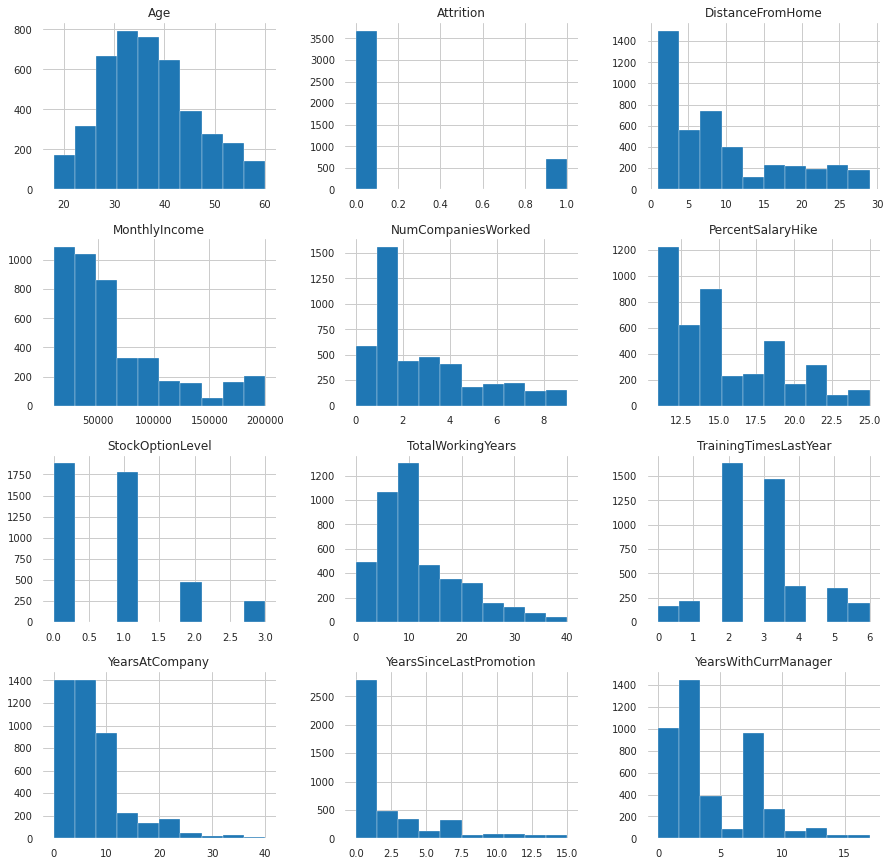

In [13]:
df.hist(figsize=(15,15))

In [14]:
corr_mat = df[vars_num].corr()
corr_mat

,Age,Attrition,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
Age,1.000000,-0.158399,0.007376,-0.045163,0.299527,-0.032561,-0.031504,0.680037,-0.028962,0.311281,0.215650,0.201580
Attrition,-0.158399,1.000000,-0.009449,-0.030160,0.042831,0.033153,-0.008164,-0.169670,-0.047586,-0.133003,-0.031423,-0.154692
DistanceFromHome,0.007376,-0.009449,1.000000,-0.022757,-0.014449,0.037720,0.009353,0.009574,-0.008957,0.030746,0.002243,0.021773
MonthlyIncome,-0.045163,-0.030160,-0.022757,1.000000,-0.021446,0.004607,0.027242,-0.034398,0.049780,0.000088,0.064470,0.023095
NumCompaniesWorked,0.299527,0.042831,-0.014449,-0.021446,1.000000,0.030064,0.016291,0.238807,-0.031335,-0.117213,-0.035855,-0.109372
PercentSalaryHike,-0.032561,0.033153,0.037720,0.004607,0.030064,1.000000,0.012104,-0.018480,-0.036720,-0.029022,-0.028654,-0.039687
StockOptionLevel,-0.031504,-0.008164,0.009353,0.027242,0.016291,0.012104,1.000000,0.003138,-0.068028,0.009369,0.019889,0.019398
TotalWorkingYears,0.680037,-0.169670,0.009574,-0.034398,0.238807,-0.018480,0.003138,1.000000,-0.041459,0.627738,0.404058,0.458640
TrainingTimesLastYear,-0.028962,-0.047586,-0.008957,0.049780,-0.031335,-0.036720,-0.068028,-0.041459,1.000000,-0.010447,0.015340,-0.015792
YearsAtCompany,0.311281,-0.133003,0.030746,0.000088,-0.117213,-0.029022,0.009369,0.627738,-0.010447,1.000000,0.618722,0.769161


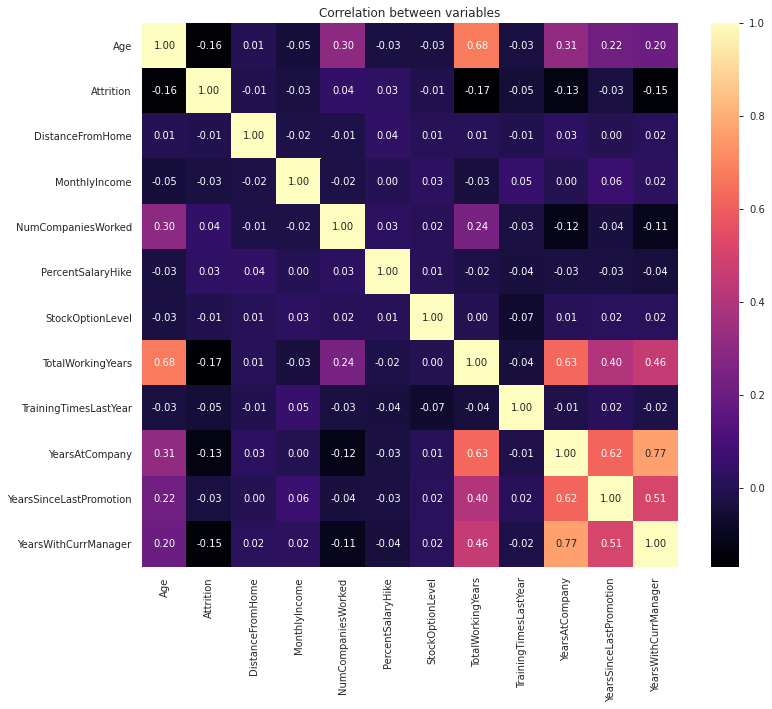

In [15]:
plt.figure(figsize=(12,10))
with sns.axes_style("darkgrid"):
    sns.heatmap(corr_mat,cmap='magma', annot=True,fmt='.2f') 
plt.title("Correlation between variables")
plt.show()

**Finding Correlation of Different Variable with Our target Variable i.e Attrition**

In [16]:
vars_num.remove('Attrition')

In [17]:
# feature scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_scale = df.copy()
df_scale[vars_num] = scaler.fit_transform(df[vars_num])

In [18]:
df_scale.head()

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager
0,1.539654,0,Travel_Rarely,Sales,-0.394720,College,Life Sciences,Female,Low,Healthcare Representative,Married,1.402261,-0.677982,-1.149633,-0.932317,-1.321838,2.483399,-0.980721,-0.679674,-1.156035
1,-0.649432,1,Travel_Frequently,Research & Development,0.098835,Below College,Life Sciences,Female,Low,Research Scientist,Single,-0.491583,-1.078374,2.126738,0.240978,-0.679563,0.156474,-0.328049,-0.369560,-0.035357
2,-0.539978,0,Travel_Frequently,Research & Development,0.962556,Master,Other,Male,Very High,Sales Executive,Married,2.720124,-0.677982,-0.057510,2.587569,-0.808018,-0.619168,-0.328049,-0.679674,-0.315526
3,0.116748,0,Non-Travel,Research & Development,-0.888275,Doctor,Life Sciences,Male,High,Human Resources,Married,0.385012,0.122804,-1.149633,2.587569,0.219622,1.707757,0.161455,1.491121,0.244813
4,-0.539978,0,Travel_Rarely,Research & Development,0.098835,Below College,Medical,Male,Low,Sales Executive,Single,-0.883420,0.523197,-0.876602,1.414274,-0.294198,-0.619168,-0.164881,-0.679674,-0.035357


In [19]:
df_dum = pd.get_dummies(df, drop_first=True, dummy_na=False,prefix=None,
    prefix_sep='_',columns=vars_cat)

In [20]:
df_dum.head()

,Age,Attrition,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,Education_Below College,Education_College,Education_Doctor,Education_Master,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobLevel_High,JobLevel_Low,JobLevel_Medium,JobLevel_Very High,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,51,0,6,131160,1.0,11,0,1.0,6,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,31,1,10,41890,0.0,23,1,6.0,3,5,1,4,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,32,0,17,193280,1.0,15,3,5.0,2,5,0,3,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,38,0,2,83210,3.0,11,3,13.0,5,8,7,5,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,32,0,10,23420,4.0,12,2,9.0,2,6,0,4,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [21]:
df_dum[vars_num] = scaler.fit_transform(df_dum[vars_num])

In [22]:
df_dum.head()

,Age,Attrition,DistanceFromHome,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,Education_Below College,Education_College,Education_Doctor,Education_Master,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Male,JobLevel_High,JobLevel_Low,JobLevel_Medium,JobLevel_Very High,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single
0,1.539654,0,-0.394720,1.402261,-0.677982,-1.149633,-0.932317,-1.321838,2.483399,-0.980721,-0.679674,-1.156035,0,1,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
1,-0.649432,1,0.098835,-0.491583,-1.078374,2.126738,0.240978,-0.679563,0.156474,-0.328049,-0.369560,-0.035357,1,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1
2,-0.539978,0,0.962556,2.720124,-0.677982,-0.057510,2.587569,-0.808018,-0.619168,-0.328049,-0.679674,-0.315526,1,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,1,0,1,0
3,0.116748,0,-0.888275,0.385012,0.122804,-1.149633,2.587569,0.219622,1.707757,0.161455,1.491121,0.244813,0,0,1,0,0,0,1,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,1,0
4,-0.539978,0,0.098835,-0.883420,0.523197,-0.876602,1.414274,-0.294198,-0.619168,-0.164881,-0.679674,-0.035357,0,1,1,0,1,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1


In [23]:
X = df_dum.drop({'Attrition'}, axis=1)
y = df_dum[['Attrition']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30 , random_state=42)

<IPython.core.display.Javascript object>

In [24]:
X_test.isnull().sum()

Age                                  0
DistanceFromHome                     0
MonthlyIncome                        0
NumCompaniesWorked                   0
PercentSalaryHike                    0
StockOptionLevel                     0
TotalWorkingYears                    0
TrainingTimesLastYear                0
YearsAtCompany                       0
YearsSinceLastPromotion              0
YearsWithCurrManager                 0
BusinessTravel_Travel_Frequently     0
BusinessTravel_Travel_Rarely         0
Department_Research & Development    0
Department_Sales                     0
Education_Below College              0
Education_College                    0
Education_Doctor                     0
Education_Master                     0
EducationField_Life Sciences         0
EducationField_Marketing             0
EducationField_Medical               0
EducationField_Other                 0
EducationField_Technical Degree      0
Gender_Male                          0
JobLevel_High            

## Random Forest for Feature Selection

In [25]:
def gridsearch_hyperparam_tunning(model_name,reg_model,param_grid):
    model = reg_model
    ran_model = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, verbose=2, n_jobs = -1,scoring='neg_mean_squared_error', return_train_score=True)
    # Fit the random search model
    ran_model.fit(X_train,y_train)
    print(ran_model.best_params_)
    y_hat = ran_model.predict(X_test)
    
    return ran_model.best_estimator_

In [26]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold, learning_curve

param_grid = [ {'n_estimators': [135,95,110], 'max_features': [5,8]}, {'bootstrap': [True]}, ] 
rm_classifier = RandomForestClassifier(random_state=1)

grid_search = GridSearchCV(rm_classifier, param_grid, cv=5,return_train_score=True)

grid_search.fit(X_train, y_train)

rnd_best = grid_search.best_estimator_

rnd_grid_best = gridsearch_hyperparam_tunning("Random Forest Classifier",rm_classifier,param_grid)


<IPython.core.display.Javascript object>

Fitting 5 folds for each of 7 candidates, totalling 35 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:   13.3s finished


{'max_features': 5, 'n_estimators': 135}


Text(0, 0.5, 'Names of the Features')

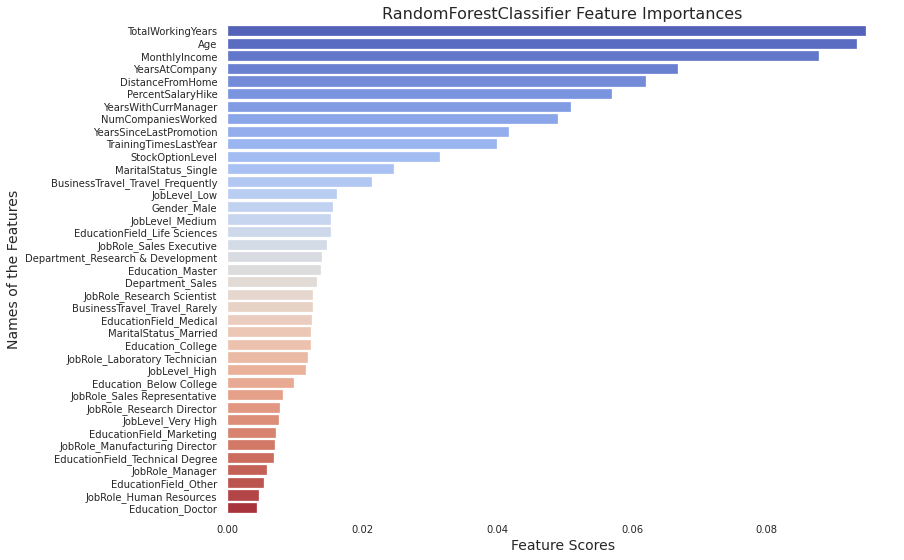

In [27]:
x_ax, y_ax = (list(x) for x in zip(*sorted(zip(rnd_best.feature_importances_, X_train.columns), 
                                                            reverse = True)))

d = {'feature_scores': x_ax, 'feature_names': y_ax}
result_df = pd.DataFrame(data=d)

fig, ax = plt.subplots(figsize=(12,9))
ax = sns.barplot(x='feature_scores', y='feature_names', data=result_df, palette="coolwarm")
plt.title('RandomForestClassifier Feature Importances', fontsize=16)
plt.xlabel('Feature Scores', fontsize=14)
plt.ylabel('Names of the Features', fontsize=14)

In [28]:
rf_model = RandomForestClassifier(n_estimators=10,max_features=3,oob_score=True,max_depth=3)

<IPython.core.display.Javascript object>

In [29]:
rf_model.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features=3,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=True, random_state=None,
                       verbose=0, warm_start=False)

In [30]:
estimator_limited = rf_model.estimators_[5]
estimator_limited

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=3, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=740718325, splitter='best')

#### So We got Important Features which we gonna feed into Our Decision Tree Model:
We will feed below features:
1. Monthly Income
2. Age
3. Total Working Years
4. Years at Company
5. Distance From Home
6. Percent Salary Hike

### Decision Tree

In [31]:
# calculate accuracy measures and confusion matrix
from sklearn import metrics

# import DecionTree classifier
from sklearn.tree import DecisionTreeClassifier

# invoking the decision tree classifier function. Using 'entropy' method of finding the split columns. 
# Other option could be gini index. 

dt_model = DecisionTreeClassifier(criterion = 'entropy' )



In [32]:
dt_model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [33]:
print (pd.DataFrame(dt_model.feature_importances_, columns = ["Imp"], index = X_train.columns))

                                        Imp
Age                                0.091392
DistanceFromHome                   0.057150
MonthlyIncome                      0.138729
NumCompaniesWorked                 0.067341
PercentSalaryHike                  0.059486
StockOptionLevel                   0.024149
TotalWorkingYears                  0.122098
TrainingTimesLastYear              0.059190
YearsAtCompany                     0.057734
YearsSinceLastPromotion            0.037905
YearsWithCurrManager               0.045407
BusinessTravel_Travel_Frequently   0.013802
BusinessTravel_Travel_Rarely       0.009483
Department_Research & Development  0.014380
Department_Sales                   0.012749
Education_Below College            0.010810
Education_College                  0.000000
Education_Doctor                   0.000000
Education_Master                   0.004237
EducationField_Life Sciences       0.000000
EducationField_Marketing           0.008923
EducationField_Medical          

In [34]:
y_predict = dt_model.predict(X_test)

In [35]:
print(dt_model.score(X_train , y_train))
print(dt_model.score(X_test, y_test))

1.0
0.979467680608365


### We can see clearly that our model gives 100 % success in Train set but reduces in Test set but not with huge margin , 
### This is most probably because we have done label encoding and it is biased now.


## Lets do regularization 

In [36]:
reg_dt_model = DecisionTreeClassifier(criterion = 'entropy', max_depth = 7)
reg_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=7, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [37]:
y_predict_reg = reg_dt_model.predict(X_test)

In [38]:
print(dt_model.score(X_train , y_train))
print (reg_dt_model.score(X_test, y_test))

1.0
0.8684410646387832


In [39]:
features = ['Age','DistanceFromHome','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike']

We can see a significant drop in Test score

Now let us pass the Important Features we got from Random Forest into DT Model

In [48]:
new_X = df_dum[features]
y = df_dum[['Attrition']]
X_train, X_test, y_train, y_test = train_test_split(new_X, y, test_size=0.30 , random_state=42)

<IPython.core.display.Javascript object>

In [49]:
reg_dt_model = DecisionTreeClassifier(criterion = 'gini', max_depth = 6,max_leaf_nodes=3)
reg_dt_model.fit(X_train, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=6, max_features=None, max_leaf_nodes=3,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [50]:
y_predict_reg = reg_dt_model.predict(X_test)

In [51]:
print(reg_dt_model.score(X_train , y_train))
print (reg_dt_model.score(X_test, y_test))

0.8359960873818063
0.8524714828897338


## We can see how the Model accuracy is almost same for Train and Test and is not Overfit

In [44]:
from sklearn import tree

In [52]:
model=tree.DecisionTreeClassifier(max_depth=5)
model.fit(X_train,y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=5, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [55]:
with open("AttritionRate.dot",'w')as f:
    f= tree.export_graphviz(reg_dt_model, feature_names=['Age','DistanceFromHome','MonthlyIncome','NumCompaniesWorked','PercentSalaryHike'],out_file=f);

In [63]:
from graphviz import Source
path = '/home/ashish/Documents/LetsUpgrade/Day 24/AttritionRate.dot'
s = Source.from_file(path)
s.view()

'/home/ashish/Documents/LetsUpgrade/Day 24/AttritionRate.dot.pdf'

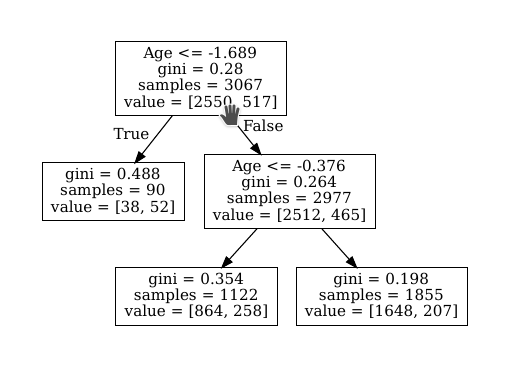